## Purpose

To compute the ML performance of the proposed method in near real-time.

In [2]:
import os 
import sys
import numpy as np
from collections import defaultdict
import CAN_objects.aid_message
import matplotlib.pyplot as plt

actt_path = os.path.join(os.path.join(os.path.expanduser("~"), "Projects", "CAN", "actt"))
os.chdir(actt_path)
sys.path.insert(0, "src") # add src folder to path so that files from this folder can be imported

from generalFunctions import unpickle
import subprocess

import importlib
importlib.reload(CAN_objects.aid_message)
from init_cancapture_from_canlog import init_cancap
import json
import seaborn as sns
import pandas as pd

from CAN_objects.capture import MappedCapture, MatchedCapture
import math
from scipy.cluster.hierarchy import single, complete, average, ward, dendrogram, linkage, fcluster

from pprint import pprint
from sklearn.metrics.cluster import normalized_mutual_info_score

from clusim.clustering import Clustering, remap2match
import clusim.sim as sim

import glob
from tqdm import tqdm
import itertools
from scipy.stats import shapiro, mannwhitneyu, ttest_ind, spearmanr
from sklearn.preprocessing import normalize, scale, MinMaxScaler, StandardScaler

## Enable the Use of Functions From the Detect Repo

In [3]:
# sys.path.insert(0, "/home/cades/Projects/CAN/detect/") # add detect folder to path so that files from this folder can be imported
sys.path.insert(0, "/home/cloud/Projects/CAN/detect/") # add detect folder to path so that files from this folder can be imported
import signal_based_preprocess_functions
print(os.getcwd())

/home/cloud/Projects/CAN/actt


## Functions

In [4]:
def from_capture_to_time_series(cap, ground_truth_dbc_path, freq):
    
    signal_multivar_ts, timepts, aid_signal_tups = signal_based_preprocess_functions.capture_to_mv_signal_timeseries(cap, ground_truth_dbc_path, min_hz_msgs=freq)

    return signal_multivar_ts, timepts, aid_signal_tups


def from_captures_to_time_series(cap_1, cap_2, ground_truth_dbc_path):
        
    signal_multivar_ts_1, timepts_1, aid_signal_tups_1 = signal_based_preprocess_functions.capture_to_mv_signal_timeseries(cap_1, ground_truth_dbc_path)
    signal_multivar_ts_2, timepts_2, aid_signal_tups_2 = signal_based_preprocess_functions.capture_to_mv_signal_timeseries(cap_2, ground_truth_dbc_path)

    return signal_multivar_ts_1, timepts_1, aid_signal_tups_1, signal_multivar_ts_2, timepts_2, aid_signal_tups_2


def remove_constant_signals(signal_multivar_ts):
    return signal_multivar_ts[:, ~np.all(signal_multivar_ts[1:] == signal_multivar_ts[:-1], axis=0)]


def partition_time_series(signal_multivar_ts, window_length, offset):
    
    n = signal_multivar_ts.shape[0]
    i = 0
    partition = []
    
    while (i + window_length) < n:
        partition.append(signal_multivar_ts[i: i + window_length,:])
        i = i + offset
        
    if i != n:
        partition.append(signal_multivar_ts[i:n,:])
        
    return partition
    
    
def process_multivariate_signals(signal_multivar_ts, aid_signal_tups, window_length, offset):
    
    # First dataframe
    # Convert matrix of time series into a dataframe
    df = pd.DataFrame({f"{tup[0]}_{tup[1]}": signal_multivar_ts[:,index] for index, tup in enumerate(aid_signal_tups)})
    # display(df)

    # Remove columns with constant values
    df = df.loc[:, (df != df.iloc[0]).any()] 
    # display(df)
    
    # Stadarization
    # df_standardized = (df-df.mean())/df.std()
    # display(df_standardized)

    # normalization
    df_standardized = (df-df.min())/(df.max()-df.min())
    
    # Partition of data frames
    n = df_standardized.shape[0]
    i = 0
    partition = []
    
    while (i + window_length) < n:
        partition.append(df_standardized.iloc[i:i + window_length, :])
        i = i + offset
        
    if i != n:
        partition.append(df_standardized.iloc[i:n, :])
        
    return partition


def process_multiple_multivariate_signals(signal_multivar_ts_1, aid_signal_tups_1, signal_multivar_ts_2, aid_signal_tups_2, window_length, offset):
    
    # First dataframe
    # Convert matrix of time series into a dataframe
    df_1 = pd.DataFrame({f"{tup[0]}_{tup[1]}": signal_multivar_ts_1[:,index] for index, tup in enumerate(aid_signal_tups_1)})
    # display(df)
    print(df_1.shape)

    # Remove columns with constant values
    df_1 = df_1.loc[:, (df_1 != df_1.iloc[0]).any()] 
    # display(df)
    
    # Stadarization
    df_1_standardized = (df_1-df_1.mean())/df_1.std()
    # display(df_2_standardized)
    
    # Partition of data frames
    n = df_1_standardized.shape[0]
    i = 0
    partition_1 = []
    
    while (i + window_length) < n:
        partition_1.append(df_1_standardized.iloc[i:i + window_length, :])
        i = i + offset
        
    if i != n:
        partition_1.append(df_1_standardized.iloc[i:n, :])
        
        
    # Second dataframe
    # Convert matrix of time series into a dataframe
    df_2 = pd.DataFrame({f"{tup[0]}_{tup[1]}": signal_multivar_ts_2[:,index] for index, tup in enumerate(aid_signal_tups_2)})
    # display(df)
    print(df_2.shape)

    # Remove columns with constant values
    df_2 = df_2.loc[:, (df_2 != df_2.iloc[0]).any()] 
    # display(df)
    
    # Stadarization
    df_2_standardized = (df_2-df_2.mean())/df_2.std()
    # display(df_2_standardized)
    
    # Partition of data frames
    n = df_2_standardized.shape[0]
    i = 0
    partition_2 = []
    
    while (i + window_length) < n:
        partition_2.append(df_2_standardized.iloc[i:i + window_length, :])
        i = i + offset
        
    if i != n:
        partition_2.append(df_2_standardized.iloc[i:n, :])
        
    return partition_1, partition_2


def upper(df):
    '''Returns the upper triangle of a correlation matrix.
    You can use scipy.spatial.distance.squareform to recreate matrix from upper triangle.
    Args:
      df: pandas or numpy correlation matrix
    Returns:
      list of values from upper triangle
    '''
    try:
        assert(type(df) == np.ndarray)
    except:
        if type(df) == pd.DataFrame:
            df = df.values
        else:
            raise TypeError('Must be np.ndarray or pd.DataFrame')
    mask = np.triu_indices(df.shape[0], k=1)
    
    return df[mask]



def randomized_test_permutations(m1, m2):
    """Nonparametric permutation testing Monte Carlo"""
    np.random.seed(0)
    rhos = []
    n_iter = 100
    true_rho, _ = spearmanr(upper(m1), upper(m2))
    # matrix permutation, shuffle the groups
    m_ids = list(m1.columns)
    m2_v = upper(m2)
    for iter in range(n_iter):
        np.random.shuffle(m_ids) # shuffle list 
        r, _ = spearmanr(upper(m1.loc[m_ids, m_ids]), m2_v)  
        rhos.append(r)
    perm_p = ((np.sum(np.abs(true_rho) <= np.abs(rhos)))+1)/(n_iter+1) # two-tailed test

    return perm_p


def compute_correlation_matrices(partition):
    
    corr_matrices = []

    for df in partition:

        # Remove columns with constant values
        df = df.loc[:, (df != df.iloc[0]).any()] 

        # Compute correlation matrix
        corr_matrices.append(df.corr(method="pearson"))
        # corr_matrices.append(np.corrcoef(df.to_numpy(), rowvar=False))
        
    return corr_matrices


def compute_similarity_from_correlation_matrices(corr_matrices):
    
    similarities = []
    
    for i in range(len(corr_matrices)-1):

        # print("raw: ", corr_matrices[i].shape, corr_matrices[i+1].shape)

        signal_names_1 = corr_matrices[i].columns.values
        signal_names_2 = corr_matrices[i+1].columns.values
        signal_names_intersection = list(set(signal_names_1).intersection(set(signal_names_2)))

        df_1 = corr_matrices[i].loc[signal_names_intersection, signal_names_intersection] 
        df_2 = corr_matrices[i+1].loc[signal_names_intersection, signal_names_intersection]
  
        # print("pro: ", df_1.shape, df_2.shape, "\n")

        similarities.append((df_1.shape[0], spearmanr(upper(df_1), upper(df_2))[0], spearmanr(upper(df_1), upper(df_2))[1]))
        
    return similarities


def compute_similarity_from_multiple_correlation_matrices(corr_matrices_1, corr_matrices_2):
    
    similarities = []
    
    if len(corr_matrices_1) <= len(corr_matrices_2):
        corr_matrices_reference = corr_matrices_1
    else:
        corr_matrices_reference = corr_matrices_2
        
    print(len(corr_matrices_reference))
            
    for i in range(len(corr_matrices_reference)):

        # print("raw: ", corr_matrices[i].shape, corr_matrices[i+1].shape)

        signal_names_1 = corr_matrices_1[i].columns.values
        signal_names_2 = corr_matrices_2[i].columns.values
        signal_names_intersection = list(set(signal_names_1).intersection(set(signal_names_2)))

        df_1 = corr_matrices_1[i].loc[signal_names_intersection, signal_names_intersection] 
        df_2 = corr_matrices_2[i].loc[signal_names_intersection, signal_names_intersection]
  
        # print("pro: ", df_1.shape, df_2.shape, "\n")

        # similarities.append((df_1.shape[0], spearmanr(upper(df_1), upper(df_2))[0], spearmanr(upper(df_1), upper(df_2))[1]))
        
        correlation = spearmanr(upper(df_1), upper(df_2))[0]
        p_value = spearmanr(upper(df_1), upper(df_2))[1]
        
        if p_value > 0.05:
            similarities.append((i, correlation, p_value))
        else:
            similarities.append(i)
            
        
    return similarities


def create_time_intervals(total_length, window, offset):
    
    # Partition of data frames
    i = 0
    intervals = []
    
    while (i + window) < total_length:
        intervals.append((i, i + window))
        i = i + offset
        
    if i != total_length:
        intervals.append((i , total_length))
        
    return intervals


    # # Partition of data frames
    # n = df_standardized.shape[0]
    # i = 0
    # partition = []
    
    # while (i + window_length) < n:
    #     partition.append(df_standardized.iloc[i:i + window_length, :])
    #     i = i + offset
        
    # if i != n:
    #     partition.append(df_standardized.iloc[i:n, :])
        
    # return partition
    

    # intervals = []
    # # offset = 0.1*offset
    
    # for i in np.arange(0, total_length - window + 1, offset, dtype=float):
    #     intervals.append((i, i + window))

    # if i + window < total_length:
    #     intervals.append((i + offset, total_length))

    # return intervals  

## File Names

In [5]:
ground_truth_dbc_path = os.path.join(actt_path, "metadata", "dbcs", "heuristic_labeled", "anonymized_020822_030640.dbc")
#testing_captures = ["correlated_masquerade_1_030804_082640", "correlated_masquerade_2_031128_011320", "correlated_masquerade_3_040322_190000"]

# training_captures = [directory for directory in os.listdir("/home/cades/Projects/CAN/actt/data-cancaptures/") if ("road_ambient_dyno" in directory) or ("road_ambient_highway" in directory)]
training_captures = [directory for directory in os.listdir("/home/cloud/Projects/CAN/actt/data-cancaptures/") if ("road_ambient_dyno" in directory) or ("road_ambient_highway" in directory)]
print(len(training_captures), training_captures, "\n")  

testing_captures = ["correlated_masquerade_1_030804_082640", "correlated_masquerade_2_031128_011320", "correlated_masquerade_3_040322_190000", 
                    "road_attack_max_speedometer_attack_1_masquerade_060215_054000", "road_attack_max_speedometer_attack_2_masquerade_060611_002640", 
                    "road_attack_max_speedometer_attack_3_masquerade_061004_181320", "road_attack_max_engine_coolant_temp_attack_masquerade_041109_063320",
                    "road_attack_reverse_light_on_attack_1_masquerade_091205_030000", "road_attack_reverse_light_on_attack_2_masquerade_100330_214640", 
                    "road_attack_reverse_light_on_attack_3_masquerade_100724_153320", "road_attack_reverse_light_off_attack_1_masquerade_080110_162000", 
                    "road_attack_reverse_light_off_attack_2_masquerade_080505_110640", "road_attack_reverse_light_off_attack_3_masquerade_080829_045320"]

print(len(testing_captures), testing_captures) 

12 ['road_ambient_dyno_drive_basic_short_020822_030640', 'road_ambient_dyno_idle_radio_infotainment_030410_144000', 'road_ambient_dyno_drive_winter_030410_144000', 'road_ambient_highway_street_driving_diagnostics_031128_011320', 'road_ambient_dyno_drive_extended_short_021215_195320', 'road_ambient_highway_street_driving_long_050305_002000', 'road_ambient_dyno_drive_extended_long_040716_134640', 'road_ambient_dyno_drive_benign_anomaly_030804_082640', 'road_ambient_dyno_exercise_all_bits_030410_144000', 'road_ambient_dyno_reverse_040322_190000', 'road_ambient_dyno_drive_radio_infotainment_041109_063320', 'road_ambient_dyno_drive_basic_long_050305_002000'] 

13 ['correlated_masquerade_1_030804_082640', 'correlated_masquerade_2_031128_011320', 'correlated_masquerade_3_040322_190000', 'road_attack_max_speedometer_attack_1_masquerade_060215_054000', 'road_attack_max_speedometer_attack_2_masquerade_060611_002640', 'road_attack_max_speedometer_attack_3_masquerade_061004_181320', 'road_attack_m

## Obtain Metadata

In [6]:
# with open("/home/cades/Projects/CAN/actt/data/capture_metadata.json") as f:
with open("/home/cloud/Projects/CAN/actt/data/capture_metadata.json") as f:
    attack_metadata = json.load(f)
    
# pprint(testing_captures)
# pprint(attack_metadata)

attack_metadata_keys = ["correlated_signal_attack_1_masquerade", "correlated_signal_attack_2_masquerade", "correlated_signal_attack_3_masquerade", 
                        "max_speedometer_attack_1_masquerade", "max_speedometer_attack_2_masquerade", "max_speedometer_attack_3_masquerade",
                        "max_engine_coolant_temp_attack_masquerade", "reverse_light_on_attack_1_masquerade", "reverse_light_on_attack_2_masquerade",
                        "reverse_light_on_attack_3_masquerade", "reverse_light_off_attack_1_masquerade", "reverse_light_off_attack_2_masquerade",
                        "reverse_light_off_attack_3_masquerade"]

print(len(attack_metadata_keys))

13


In [7]:
print(attack_metadata_keys[0])
attack_metadata["correlated_signal_attack_1_masquerade"]

correlated_signal_attack_1_masquerade


{'description': 'start from driving; accelerate; start injecting; car rolls to stop; stop injecting; accelerate',
 'elapsed_sec': 33.101852,
 'injection_data_str': '595945450000FFFF',
 'injection_id': '0x6e0',
 'injection_interval': [9.191851, 30.050109],
 'modified': True,
 'on_dyno': True}

## Experiments on a Single Capture File (Distribution-Based)

In [8]:
# import pickle

# def unpickle(filepath):
#     """
#     Input:
#     -filepath: the file path where the pickled object you want to read in is stored
#     Output:
#     -obj: the object you want to read in
#     """
#     pickle_file = open(filepath, 'rb')
#     obj = pickle.load(pickle_file)
#     pickle_file.close()
#     return obj


# tag = training_captures[-1]
# print(tag)

# cancap = unpickle(os.path.join(actt_path, "data-cancaptures", tag, 'capture.pkl'))
# mapped_capture = MappedCapture.init_from_dbc(cancap, ground_truth_dbc_path)


In [9]:
# min_hz_msgs = 100

# max_t_delta = 1/min_hz_msgs +.005
# aid_signal_tups = [(aid, i, s.name) for aid, mp in mapped_capture.mapped_payload_dict.items() if np.median(np.diff(mp.times)) < max_t_delta and len(mp.nonconst_bits) > 0 for i, s in enumerate(mp.signal_list)]

# print(len(aid_signal_tups), aid_signal_tups)


In [10]:
signal_multivar_ts, timepts, aid_signal_tups = from_capture_to_time_series(training_captures[-1], ground_truth_dbc_path, freq=10)
signal_multivar_ts.shape

(12510, 337)

In [11]:
display(signal_multivar_ts)
display(signal_multivar_ts.shape)

array([[  148,     1, 15026, ...,     0,     0,     0],
       [  148,     1, 15023, ...,     0,     0,     0],
       [  148,     1, 15023, ...,     0,     0,     0],
       ...,
       [  133,     1, 15011, ...,     1,     0,     0],
       [  133,     1, 15014, ...,     1,     0,     0],
       [  133,     1, 15014, ...,     1,     0,     0]])

(12510, 337)

In [12]:
timepts

array([0.0000e+00, 1.0000e-01, 2.0000e-01, ..., 1.2507e+03, 1.2508e+03,
       1.2509e+03])

In [13]:
aid_signal_tups

[(14, 0, 'Unknown_0'),
 (14, 1, 'Unknown_1'),
 (14, 2, 'Unknown_2'),
 (51, 0, 'Unknown_0'),
 (51, 1, 'Unknown_1'),
 (51, 2, 'Unknown_2'),
 (51, 3, 'Unknown_3'),
 (51, 4, 'Unknown_4'),
 (51, 5, 'Unknown_5'),
 (51, 6, 'Unknown_6'),
 (60, 0, 'Unknown_0'),
 (60, 1, 'Unknown_1'),
 (61, 0, 'Unknown_0'),
 (61, 1, 'Unknown_1'),
 (61, 2, 'Unknown_2'),
 (61, 3, 'Unknown_3'),
 (61, 4, 'Unknown_4'),
 (167, 0, 'Unknown_0'),
 (167, 1, 'Unknown_1'),
 (167, 2, 'Unknown_2'),
 (167, 3, 'Unknown_3'),
 (167, 4, 'Unknown_4'),
 (167, 5, 'Unknown_5'),
 (167, 6, 'Unknown_6'),
 (167, 7, 'Unknown_7'),
 (167, 8, 'Unknown_8'),
 (186, 0, 'Unknown_0'),
 (186, 1, 'Unknown_1'),
 (186, 2, 'Unknown_2'),
 (186, 3, 'Unknown_3'),
 (186, 4, 'Unknown_4'),
 (186, 5, 'Unknown_5'),
 (186, 6, 'Unknown_6'),
 (186, 7, 'Unknown_7'),
 (192, 0, 'Unknown_0'),
 (192, 1, 'Unknown_1'),
 (192, 2, 'Unknown_2'),
 (208, 0, 'Unknown_0'),
 (208, 1, 'Unknown_1'),
 (208, 2, 'Unknown_2'),
 (208, 3, 'Unknown_3'),
 (208, 4, 'Unknown_4'),
 (208, 5,

In [14]:
timepts[-1]/60

20.848333333333336

In [15]:
np.diff(timepts)

array([0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1])

## Partition Time Series Benign

In [16]:
window = signal_multivar_ts.shape[0]
offset = window
partition_training = process_multivariate_signals(signal_multivar_ts, aid_signal_tups, window, offset)

In [17]:
print(len(partition_training))
partition_training[0]

1


,14_0,14_2,51_0,51_1,51_2,51_4,51_5,51_6,60_0,60_1,...,1694_3,1694_4,1760_0,1760_1,1760_2,1760_3,1788_3,1788_6,1788_8,1788_9
0,0.816327,0.492985,0.0,0.478431,0.0,0.133333,0.0,0.6,1.0,0.117647,...,0.0,1.000000,0.0,0.0,0.0,0.0,0.496897,0.247532,0.0,0.0
1,0.816327,0.492247,0.0,0.443137,0.0,0.733333,0.0,0.6,1.0,0.117647,...,0.0,1.000000,0.0,0.0,0.0,0.0,0.496897,0.247532,0.0,0.0
2,0.816327,0.492247,0.0,0.466667,0.0,0.333333,0.0,0.6,1.0,0.117647,...,0.0,1.000000,0.0,0.0,0.0,0.0,0.496649,0.247532,0.0,0.0
3,0.816327,0.492985,0.0,0.427451,0.0,1.000000,0.0,0.6,1.0,0.058824,...,0.0,0.666667,0.0,0.0,0.0,0.0,0.496897,0.247532,0.0,0.0
4,0.816327,0.492247,0.0,0.450980,0.0,0.600000,0.0,0.6,1.0,0.058824,...,0.0,0.666667,0.0,0.0,0.0,0.0,0.496897,0.247532,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12505,0.510204,0.488555,0.0,0.443137,0.0,0.733333,0.0,0.6,1.0,0.058824,...,0.0,0.666667,0.0,0.0,0.0,0.0,0.493174,0.247532,1.0,0.0
12506,0.510204,0.489294,0.0,0.466667,0.0,0.333333,0.0,0.6,1.0,0.000000,...,0.0,0.666667,0.0,0.0,0.0,0.0,0.493423,0.247532,1.0,0.0
12507,0.510204,0.489294,0.0,0.427451,0.0,1.000000,0.0,0.6,1.0,0.058824,...,0.0,0.666667,0.0,0.0,0.0,0.0,0.492678,0.247532,1.0,0.0
12508,0.510204,0.490032,0.0,0.450980,0.0,0.600000,0.0,0.6,1.0,0.058824,...,0.0,0.666667,0.0,0.0,0.0,0.0,0.492678,0.247532,1.0,0.0


## Compute Correlation Matrices

In [18]:
corr_matrices_training = compute_correlation_matrices(partition_training)

In [19]:
len(corr_matrices_training)

1

In [20]:
[corr_matrices_training[i].shape for i in range(len(corr_matrices_training))]

[(211, 211)]

In [21]:
corr_sample_training = np.concatenate([upper(corr_matrices_training[i]) for i in range(len(corr_matrices_training))])
len(corr_sample_training)

22155

In [22]:
corr_sample_training

array([-0.80499476,  0.05835573, -0.15690632, ..., -0.12655689,
        0.22231895, -0.01718131])

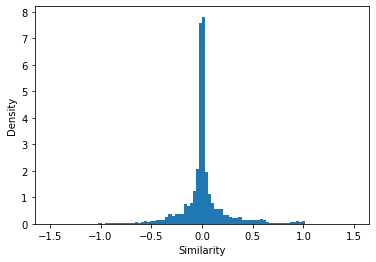

In [23]:
fig, ax = plt.subplots()

ax.hist(corr_sample_training, bins=100, range=(-1.5, 1.5), density=True)

ax.set_xlabel("Similarity")
ax.set_ylabel("Density")

plt.show()

## Partition Time Series Attack

In [24]:
testing_captures

['correlated_masquerade_1_030804_082640',
 'correlated_masquerade_2_031128_011320',
 'correlated_masquerade_3_040322_190000',
 'road_attack_max_speedometer_attack_1_masquerade_060215_054000',
 'road_attack_max_speedometer_attack_2_masquerade_060611_002640',
 'road_attack_max_speedometer_attack_3_masquerade_061004_181320',
 'road_attack_max_engine_coolant_temp_attack_masquerade_041109_063320',
 'road_attack_reverse_light_on_attack_1_masquerade_091205_030000',
 'road_attack_reverse_light_on_attack_2_masquerade_100330_214640',
 'road_attack_reverse_light_on_attack_3_masquerade_100724_153320',
 'road_attack_reverse_light_off_attack_1_masquerade_080110_162000',
 'road_attack_reverse_light_off_attack_2_masquerade_080505_110640',
 'road_attack_reverse_light_off_attack_3_masquerade_080829_045320']

In [25]:
signal_multivar_ts, timepts, aid_signal_tups = from_capture_to_time_series(testing_captures[0], ground_truth_dbc_path, freq=100)
timepts[-1]

33.99

## Partition Time Series Attack

In [26]:
window = 50
offset = 10
partition_testing = process_multivariate_signals(signal_multivar_ts, aid_signal_tups, window, offset)

In [27]:
print(len(partition_testing))
partition_testing[0]

336


,14_0,14_2,51_0,51_1,51_2,51_4,51_5,51_6,167_3,167_4,...,852_0,852_2,852_3,1505_0,1505_1,1505_5,1760_0,1760_1,1760_2,1760_3
0,0.333333,0.678022,0.0,0.325490,0.0,0.600000,0.032291,0.636364,0.0,0.376543,...,0.452632,0.518519,0.571429,0.994444,1.0,0.890411,0.067499,0.322461,0.459807,0.026308
1,0.333333,0.678022,0.0,0.325490,0.0,0.600000,0.032291,0.636364,0.0,0.376543,...,0.452632,0.518519,0.571429,0.994444,1.0,0.890411,0.067499,0.322461,0.459807,0.026308
2,0.333333,0.678022,0.0,0.321569,0.0,0.666667,0.032291,0.636364,0.0,0.382716,...,0.452632,0.500000,0.714286,0.994444,1.0,0.890411,0.067499,0.322461,0.461951,0.026369
3,0.333333,0.674725,0.0,0.317647,0.0,0.733333,0.032291,0.636364,0.0,0.376543,...,0.452632,0.500000,0.714286,0.994444,1.0,0.890411,0.067499,0.322461,0.461951,0.026369
4,0.333333,0.678022,0.0,0.313725,0.0,0.800000,0.032291,0.636364,0.0,0.376543,...,0.452632,0.490741,0.785714,0.994444,1.0,0.897260,0.068115,0.326168,0.464094,0.026369
5,0.333333,0.678022,0.0,0.309804,0.0,0.866667,0.032291,0.636364,0.0,0.382716,...,0.452632,0.490741,0.785714,0.994444,1.0,0.897260,0.068115,0.326168,0.465166,0.026430
6,0.333333,0.671429,0.0,0.305882,0.0,0.933333,0.032291,0.636364,0.0,0.370370,...,0.452632,0.462963,1.000000,0.994444,1.0,0.897260,0.068115,0.326909,0.465166,0.026430
7,0.333333,0.678022,0.0,0.301961,0.0,1.000000,0.032291,0.636364,0.0,0.370370,...,0.452632,0.462963,1.000000,0.994444,1.0,0.890411,0.068115,0.326909,0.465166,0.026430
8,0.333333,0.674725,0.0,0.360784,0.0,0.000000,0.032291,0.636364,0.0,0.382716,...,0.452632,0.462963,1.000000,0.988889,1.0,0.897260,0.069040,0.329133,0.465166,0.026491
9,0.333333,0.678022,0.0,0.356863,0.0,0.066667,0.032291,0.636364,0.0,0.376543,...,0.452632,0.592593,0.000000,0.988889,1.0,0.897260,0.069040,0.329133,0.465166,0.026491


## Compute Correlation Matrices

In [28]:
corr_matrices_testing = compute_correlation_matrices(partition_testing)
len(corr_matrices_testing)

336

In [29]:
corr_matrices_testing[0].shape

(23, 23)

In [30]:
# for i in tqdm(range(len(corr_matrices_testing))):
    
#     corr_sample_testing = upper(corr_matrices_testing[i])
    
#     p_value = mannwhitneyu(corr_sample_training, corr_sample_testing)[1]
    
#     if p_value <= 0.05:
        
#         print(i, mannwhitneyu(corr_sample_training, corr_sample_testing))
        
# #         fig, ax = plt.subplots()

# #         ax.hist(corr_sample_training, bins=50, alpha=0.5, density=True, label="Benign")
# #         ax.set_xlabel("Similarity")
# #         ax.set_ylabel("Density")
# #         ax.hist(corr_sample_testing, bins=50, alpha=0.5, density=True, label="Attack")
# #         ax.legend(loc="upper right")

# #         plt.show() 

In [31]:
display(attack_metadata_keys[0])
attack_metadata[attack_metadata_keys[0]]

'correlated_signal_attack_1_masquerade'

{'description': 'start from driving; accelerate; start injecting; car rolls to stop; stop injecting; accelerate',
 'elapsed_sec': 33.101852,
 'injection_data_str': '595945450000FFFF',
 'injection_id': '0x6e0',
 'injection_interval': [9.191851, 30.050109],
 'modified': True,
 'on_dyno': True}

## Experiments Comparing Distributions

## Hypothesis Testing (Single Attack)

In [32]:
# signals_training = corr_matrices_training[0].columns.values

window = 100
offset = 1

print("Processing: ", attack_metadata_keys[0])
signal_multivar_ts, timepts, aid_signal_tups = from_capture_to_time_series(testing_captures[0], ground_truth_dbc_path, freq=100)
# print(timepts[-1])

partition_testing = process_multivariate_signals(signal_multivar_ts, aid_signal_tups, window, offset) # Partition time series
print("intervals: ", len(partition_testing))

# # display(partition_testing[0])
# # display(partition_testing[1])
# # display(partition_testing[-1])
corr_matrices_testing = compute_correlation_matrices(partition_testing) # Compute Correlations

# total_length = int(np.ceil(timepts[-1])) 
total_length = timepts[-1]
print("total length (s): ", total_length) 
# print(timepts[-1], total_length)
intervals_testing = create_time_intervals(total_length, window/100, offset/100)
print(len(intervals_testing), intervals_testing)
print("attack interval (s): ", attack_metadata[attack_metadata_keys[0]]["injection_interval"][0], attack_metadata[attack_metadata_keys[0]]["injection_interval"][1])

tp, fp, fn, tn = 0, 0, 0, 0

for index_interval in tqdm(range(len(intervals_testing))):
    
    # # Compute signal names intersection
    # signals_testing = corr_matrices_testing[index_interval].columns.values
    # signal_names_intersection = list(set(signals_training).intersection(set(signals_testing)))

    # # print(signal_names_intersection)
    
    # # Filter correlation matrices by common names
    # corr_sample_training = upper(corr_matrices_training[0].loc[signal_names_intersection, signal_names_intersection])
    # corr_sample_testing = upper(corr_matrices_testing[index_interval].loc[signal_names_intersection, signal_names_intersection])

    # Get correlation matrices
    corr_sample_testing = upper(corr_matrices_testing[index_interval])
     
    # Do hypothesis test
    mannwhitneyu_test = mannwhitneyu(corr_sample_training, corr_sample_testing)
    # print((index_interval, len(corr_sample_training), len(corr_sample_testing), mannwhitneyu_test[0], mannwhitneyu_test[1]))

    # print(intervals_testing[index_interval][0], intervals_testing[index_interval][1], attack_metadata[attack_metadata_keys[0]]["injection_interval"][0], attack_metadata[attack_metadata_keys[0]]["injection_interval"][1])

    if mannwhitneyu_test[1] <= 0.05: # positive detection
        if ((intervals_testing[index_interval][1] > attack_metadata[attack_metadata_keys[0]]["injection_interval"][0] and intervals_testing[index_interval][0] < attack_metadata[attack_metadata_keys[0]]["injection_interval"][0])
               or (intervals_testing[index_interval][0] > attack_metadata[attack_metadata_keys[0]]["injection_interval"][0] and intervals_testing[index_interval][1] < attack_metadata[attack_metadata_keys[0]]["injection_interval"][1])
                   or (intervals_testing[index_interval][0] < attack_metadata[attack_metadata_keys[0]]["injection_interval"][1] and intervals_testing[index_interval][1] > attack_metadata[attack_metadata_keys[0]]["injection_interval"][1])):
            tp += 1
        else:
            fp += 1
    else: # negative detection
        if ((intervals_testing[index_interval][1] > attack_metadata[attack_metadata_keys[0]]["injection_interval"][0] and intervals_testing[index_interval][0] < attack_metadata[attack_metadata_keys[0]]["injection_interval"][0])
               or (intervals_testing[index_interval][0] > attack_metadata[attack_metadata_keys[0]]["injection_interval"][0] and intervals_testing[index_interval][1] < attack_metadata[attack_metadata_keys[0]]["injection_interval"][1])
                   or (intervals_testing[index_interval][0] < attack_metadata[attack_metadata_keys[0]]["injection_interval"][1] and intervals_testing[index_interval][1] > attack_metadata[attack_metadata_keys[0]]["injection_interval"][1])):
            fn += 1
        else:
            tn += 1
            
# precision
if tp + fp != 0:            
    precision = tp/(tp + fp)
else:
    precision = np.nan

# recall
if tp + fn != 0:
    recall = tp/(tp + fn)
else:
    recall = np.nan

# f1
if precision + recall != 0:
    f1 = 2*((precision*recall)/(precision + recall))

else:
    f1 = np.nan

# fpr
if fp + tn != 0:
    fpr = fp/(fp + tn)
else:
    fpr = np.nan

# fnr
if fn + tp != 0:
    fnr = fn/(fn + tp)
else:
    fnr = np.nan

# mcc
if (tp+fp == 0) or (tp+fn == 0) or (tn+fp == 0) or (tn+fn == 0):
    mcc = (tp*tn) - (fp*fn)
else:
    mcc = (tp*tn - fp*fn)/(math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)))

print(f"tp: {tp}, tn: {tn}, fp: {fp}, fn: {fn}")
print(f"precision: {precision:.3f}, recall: {recall:.3f}, f1: {f1:.3f}, fpr: {fpr:.3f}, fnr: {fnr:.3f}, mcc: {mcc:.3f}")
print(f"positive_intervals: {tp+fn:.3f}, negative_intervals: {tn+fp:.3f}\n")

Processing:  correlated_signal_attack_1_masquerade
intervals:  2901
total length (s):  33.99
2900 [(0, 5.0), (0.01, 5.01), (0.02, 5.02), (0.03, 5.03), (0.04, 5.04), (0.05, 5.05), (0.060000000000000005, 5.06), (0.07, 5.07), (0.08, 5.08), (0.09, 5.09), (0.09999999999999999, 5.1), (0.10999999999999999, 5.11), (0.11999999999999998, 5.12), (0.12999999999999998, 5.13), (0.13999999999999999, 5.14), (0.15, 5.15), (0.16, 5.16), (0.17, 5.17), (0.18000000000000002, 5.18), (0.19000000000000003, 5.19), (0.20000000000000004, 5.2), (0.21000000000000005, 5.21), (0.22000000000000006, 5.22), (0.23000000000000007, 5.23), (0.24000000000000007, 5.24), (0.25000000000000006, 5.25), (0.26000000000000006, 5.26), (0.2700000000000001, 5.2700000000000005), (0.2800000000000001, 5.28), (0.2900000000000001, 5.29), (0.3000000000000001, 5.3), (0.3100000000000001, 5.3100000000000005), (0.3200000000000001, 5.32), (0.3300000000000001, 5.33), (0.34000000000000014, 5.34), (0.35000000000000014, 5.3500000000000005), (0.36000

100%|██████████| 2900/2900 [00:12<00:00, 241.64it/s]

tp: 509, tn: 420, fp: 0, fn: 1971
precision: 1.000, recall: 0.205, f1: 0.341, fpr: 0.000, fnr: 0.795, mcc: 0.190
positive_intervals: 2480.000, negative_intervals: 420.000



## Hypothesis Testing (All Attacks)

In [33]:
# signals_training = corr_matrices_training[0].columns.values

window = 100
offset = 1

for index_attack in range(len(attack_metadata_keys)):

    print("Processing: ", attack_metadata_keys[index_attack])
    signal_multivar_ts, timepts, aid_signal_tups = from_capture_to_time_series(testing_captures[index_attack], ground_truth_dbc_path, freq=100)
    
    partition_testing = process_multivariate_signals(signal_multivar_ts, aid_signal_tups, window, offset) # Partition time series
    print("intervals: ", len(partition_testing))

    # display(partition_testing[0])
    # display(partition_testing[1])
    # display(partition_testing[-1])
    
    corr_matrices_testing = compute_correlation_matrices(partition_testing) # Compute Correlations
    
    # total_length = int(np.ceil(timepts[-1]))  
    total_length = timepts[-1]
    print("total length (s): ", total_length)
    intervals_testing = create_time_intervals(total_length, window/100, offset/100)
    # print("intervals testing: ", len(intervals_testing), intervals_testing)
    print("attack interval (s): ", attack_metadata[attack_metadata_keys[index_attack]]["injection_interval"][0], attack_metadata[attack_metadata_keys[index_attack]]["injection_interval"][1])
    
    tp, fp, fn, tn = 0, 0, 0, 0

    for index_interval in range(len(intervals_testing)):

        # Get correlation matrices
        corr_sample_testing = upper(corr_matrices_testing[index_interval])

        # Do hypothesis test
        mannwhitneyu_test = mannwhitneyu(corr_sample_training, corr_sample_testing)
        # print((index_interval, len(corr_sample_training), len(corr_sample_testing), mannwhitneyu_test[0], mannwhitneyu_test[1]))

        if mannwhitneyu_test[1] <= 0.05: # positive detection
            if ((intervals_testing[index_interval][1] > attack_metadata[attack_metadata_keys[index_attack]]["injection_interval"][0] and intervals_testing[index_interval][0] < attack_metadata[attack_metadata_keys[index_attack]]["injection_interval"][0])
                   or (intervals_testing[index_interval][0] > attack_metadata[attack_metadata_keys[index_attack]]["injection_interval"][0] and intervals_testing[index_interval][1] < attack_metadata[attack_metadata_keys[index_attack]]["injection_interval"][1])
                       or (intervals_testing[index_interval][0] < attack_metadata[attack_metadata_keys[index_attack]]["injection_interval"][1] and intervals_testing[index_interval][1] > attack_metadata[attack_metadata_keys[index_attack]]["injection_interval"][1])):
                tp += 1
            else:
                fp += 1
        else: # negative detection
            if ((intervals_testing[index_interval][1] > attack_metadata[attack_metadata_keys[index_attack]]["injection_interval"][0] and intervals_testing[index_interval][0] < attack_metadata[attack_metadata_keys[index_attack]]["injection_interval"][0])
                   or (intervals_testing[index_interval][0] > attack_metadata[attack_metadata_keys[index_attack]]["injection_interval"][0] and intervals_testing[index_interval][1] < attack_metadata[attack_metadata_keys[index_attack]]["injection_interval"][1])
                       or (intervals_testing[index_interval][0] < attack_metadata[attack_metadata_keys[index_attack]]["injection_interval"][1] and intervals_testing[index_interval][1] > attack_metadata[attack_metadata_keys[index_attack]]["injection_interval"][1])):
                fn += 1
            else:
                tn += 1
    # precision
    if tp + fp != 0:            
        precision = tp/(tp + fp)
    else:
        precision = np.nan
        
    # recall
    if tp + fn != 0:
        recall = tp/(tp + fn)
    else:
        recall = np.nan
        
    # f1
    if precision + recall != 0:
        f1 = 2*((precision*recall)/(precision + recall))
        
    else:
        f1 = np.nan
        
    # fpr
    if fp + tn != 0:
        fpr = fp/(fp + tn)
    else:
        fpr = np.nan

    # fnr
    if fn + tp != 0:
        fnr = fn/(fn + tp)
    else:
        fnr = np.nan

    # mcc
    if (tp+fp == 0) or (tp+fn == 0) or (tn+fp == 0) or (tn+fn == 0):
        mcc = (tp*tn) - (fp*fn)
    else:
        mcc = (tp*tn - fp*fn)/(math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)))

    print(f"tp: {tp}, tn: {tn}, fp: {fp}, fn: {fn}")
    print(f"precision: {precision:.3f}, recall: {recall:.3f}, f1: {f1:.3f}, fpr: {fpr:.3f}, fnr: {fnr:.3f}, mcc: {mcc:.3f}")
    print(f"positive_intervals: {tp+fn:.3f}, negative_intervals: {tn+fp:.3f}\n")

Processing:  correlated_signal_attack_1_masquerade
intervals:  3301
total length (s):  33.99
attack interval (s):  9.191851 30.050109
tp: 495, tn: 827, fp: 287, fn: 1691
precision: 0.633, recall: 0.226, f1: 0.334, fpr: 0.258, fnr: 0.774, mcc: -0.035
positive_intervals: 2186.000, negative_intervals: 1114.000

Processing:  correlated_signal_attack_2_masquerade
intervals:  2801
total length (s):  28.99
attack interval (s):  6.830477 28.225908
tp: 593, tn: 509, fp: 75, fn: 1623
precision: 0.888, recall: 0.268, f1: 0.411, fpr: 0.128, fnr: 0.732, mcc: 0.133
positive_intervals: 2216.000, negative_intervals: 584.000

Processing:  correlated_signal_attack_3_masquerade
intervals:  1601
total length (s):  16.99
attack interval (s):  4.318482 16.95706
tp: 235, tn: 226, fp: 106, fn: 1034
precision: 0.689, recall: 0.185, f1: 0.292, fpr: 0.319, fnr: 0.815, mcc: -0.133
positive_intervals: 1269.000, negative_intervals: 332.000

Processing:  max_speedometer_attack_1_masquerade
intervals:  8801
total len